In [1]:
import numpy as np
import cv2 as cv
import glob
from google.colab.patches import cv2_imshow

In [2]:
# Configuración del tablero de ajedrez
chessboard_size = (10, 7)  # Número de esquinas internas del tablero (ajusta según tu patrón)
square_size = 1.0  # Tamaño del cuadrado en unidades, puede ser 1.0 si no necesitas escalado

In [3]:
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [4]:
# Crea los puntos 3D de las esquinas del tablero en el mundo real (en 3D)
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
objp *= square_size

In [5]:
# Arreglos para almacenar puntos 3D en el mundo real y puntos 2D en las imágenes
objpoints = []  # Puntos 3D en el mundo real
imgpoints = []  # Puntos 2D en la imagen

In [10]:
# Cargar las imágenes de calibración
images = glob.glob('/content/drive/MyDrive/Semestre 8/Visión por computador /Clase_11/Imagenes/*.jpeg')

In [11]:
for fname in images:
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Encuentra las esquinas del tablero de ajedrez
    ret, corners = cv.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        objpoints.append(objp)

        # Refina las esquinas encontradas usando el criterio de terminación
        corners_refined = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners_refined)

        # Dibuja y muestra las esquinas encontradas
        cv.drawChessboardCorners(img, chessboard_size, corners_refined, ret)
        cv2_imshow(img)  # Usa cv2_imshow en lugar de cv.imshow en Google Colab
        cv.waitKey(500)

cv.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Calibra la cámara
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

print("Matriz de la cámara:\n", camera_matrix)
print("Coeficientes de distorsión:\n", dist_coeffs)

Matriz de la cámara:
 [[887.86593741   0.         466.2065515 ]
 [  0.         893.10713991 644.0734674 ]
 [  0.           0.           1.        ]]
Coeficientes de distorsión:
 [[ 0.18637377 -0.56257264  0.00849439  0.00275732  0.56677814]]


In [13]:
FX = camera_matrix[0, 0]
FY = camera_matrix[1, 1]
CX = camera_matrix[0, 2]
CY = camera_matrix[1, 2]

In [14]:
print("FX:", FX)
print("FY:", FY)
print("CX:", CX)
print("CY:",CY)

FX: 887.8659374053835
FY: 893.1071399089968
CX: 466.2065514950588
CY: 644.073467395276


Imagen Original:


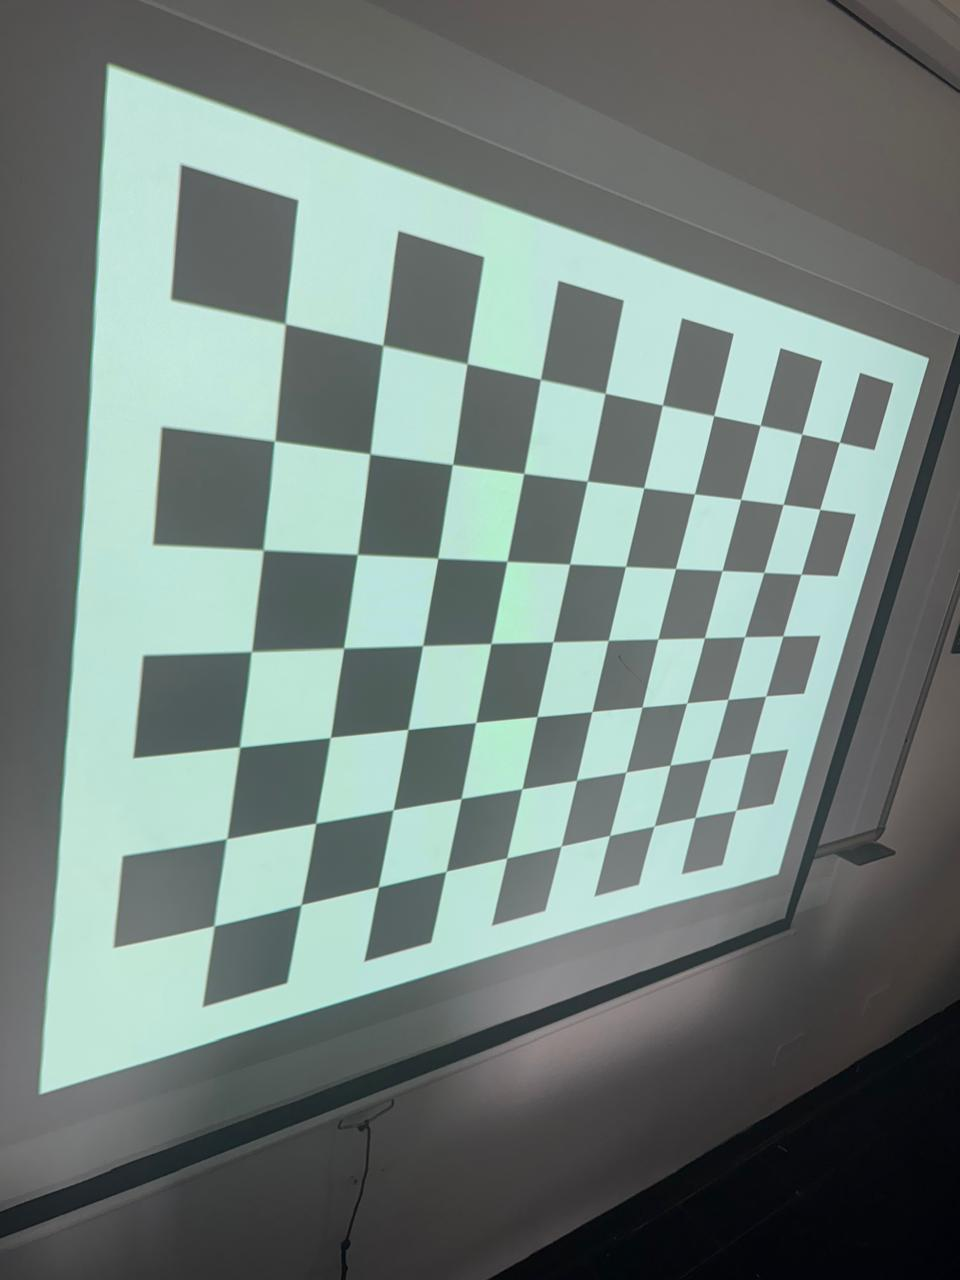

Imagen sin Distorsión:


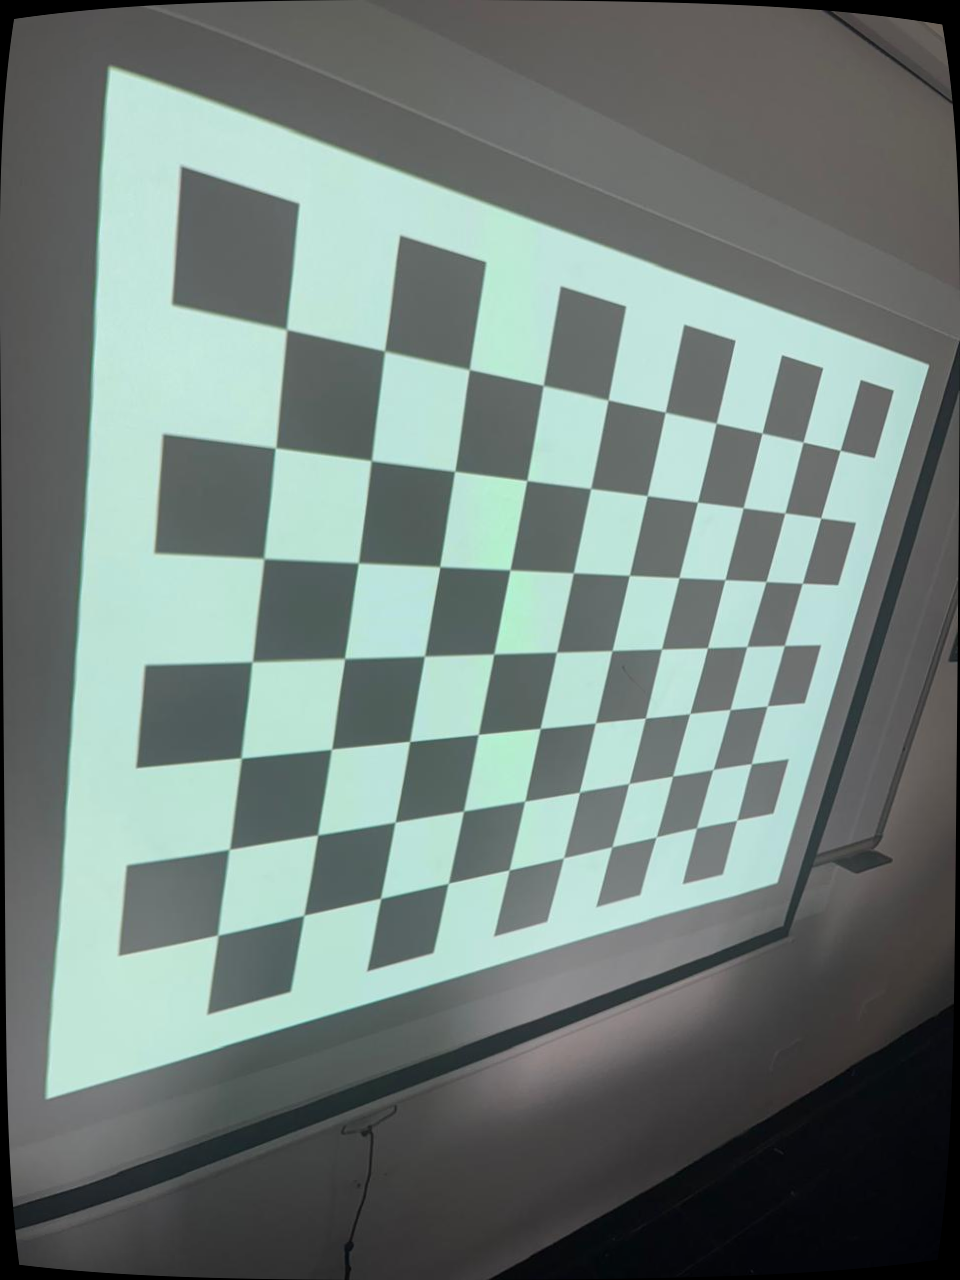

In [15]:
img = cv.imread(images[0])  # Carga una de las imágenes
h, w = img.shape[:2]
new_camera_matrix, roi = cv.getOptimalNewCameraMatrix(camera_matrix, dist_coeffs, (w, h), 1, (w, h))

# Corrige la distorsión
undistorted_img = cv.undistort(img, camera_matrix, dist_coeffs, None, new_camera_matrix)

# Muestra la imagen original y la imagen corregida en Colab
print("Imagen Original:")
cv2_imshow(img)  # Muestra la imagen original
print("Imagen sin Distorsión:")
cv2_imshow(undistorted_img)  # Muestra la imagen corregid

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Carga las imágenes (asegúrate de que los nombres de archivo sean correctos)
img1 = cv2.imread('/content/drive/MyDrive/Semestre 8/Visión por computador /Clase_11/WhatsApp Image 2024-11-05 at 8.46.52 PM.jpeg', cv2.IMREAD_GRAYSCALE)  # Cambia esta ruta
img2 = cv2.imread('/content/drive/MyDrive/Semestre 8/Visión por computador /Clase_11/WhatsApp Image 2024-11-05 at 8.46.54 PM.jpeg', cv2.IMREAD_GRAYSCALE)  # Cambia esta ruta

In [17]:
# Inicializa el detector SIFT
sift = cv2.SIFT_create()

In [18]:
# Detecta y calcula los descriptores en ambas imágenes
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

In [19]:
# Configura el emparejador de características
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
matches = bf.knnMatch(des1, des2, k=2)

In [20]:
# Aplicar el test de ratio de Lowe
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

In [21]:
# Visualiza las correspondencias
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

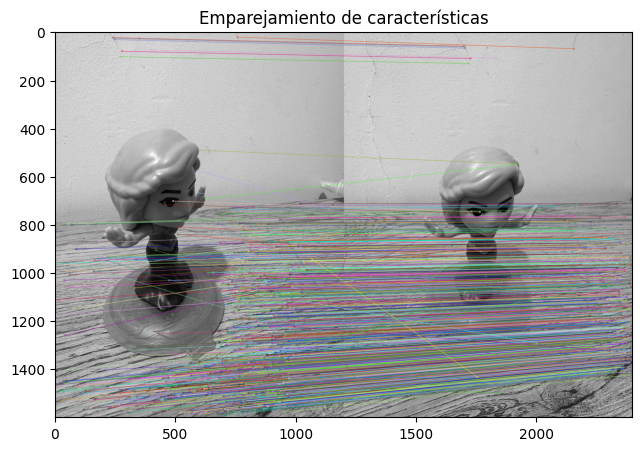

In [22]:
plt.figure(figsize=(10, 5))
plt.imshow(img_matches)
plt.title("Emparejamiento de características")
plt.show()

In [23]:
# Extrae las posiciones de los puntos clave emparejados
pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

In [24]:
# Parámetros intrínsecos de la cámara
FX, FY, CX, CY = 3103.6804878893486, 3099.5095584378187, 1517.9856610352224, 1515.5235759332113
K = np.array([[FX, 0, CX], [0, FY, CY], [0, 0, 1]])  # Matriz intrínseca

In [25]:
# Matriz esencial usando los puntos emparejados
E, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
_, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)

In [26]:
# Matrices de proyección
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # Proyección de la primera cámara
P2 = np.hstack((R, t))  # Proyección de la segunda cámara
P1 = K @ P1
P2 = K @ P2

In [27]:
# Triangulación de puntos
points_4D = cv2.triangulatePoints(P1, P2, pts1, pts2)
points_3D = points_4D / points_4D[3]  # Convierte de coordenadas homogéneas a Cartesianas
points_3D = points_3D[:3, :].T  # Ajusta la forma de los puntos

In [28]:
# Visualización básica de los puntos 3D
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

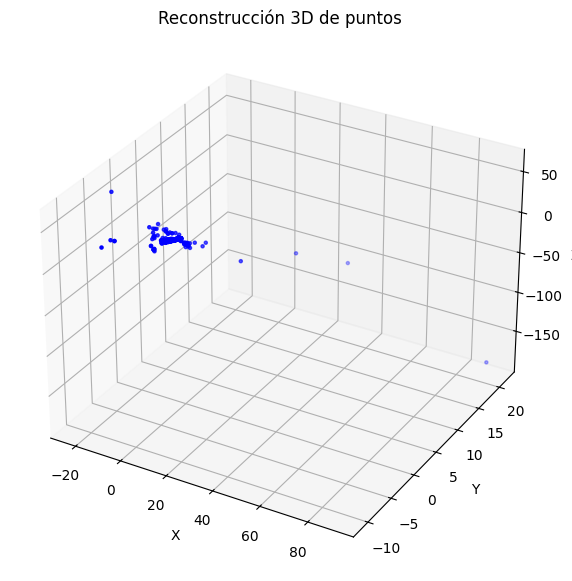

In [29]:
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_3D[:, 0], points_3D[:, 1], points_3D[:, 2], c='b', marker='o', s=5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title("Reconstrucción 3D de puntos")
plt.show()